# Show, Attend and Tell: Neural Image Caption Generation with Visual Attention 

## Problem Statement

> Implement a clean working code and extract results using Tensorflow2/Keras/PyTorch for the research paper [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf).

## What is  image captioning?

To build networks capable of perceiving contextual subtleties in images, to relate observations to both the scene and the real world, and to output succinct and accurate image descriptions.

## Resources referred

1. Papers:
    - [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/pdf/1502.03044.pdf)
    - [Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation](https://arxiv.org/pdf/1406.1078.pdf)
    - [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/pdf/1411.4389.pdf)
    - [Deep Visual-Semantic Alignments for Generating Image Descriptions](http://proceedings.mlr.press/v37/xuc15.pdf)
    
2. Implementations:
    - [DeepRNN/image_captioning](https://github.com/DeepRNN/image_captioning)
    - [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/text/image_captioning#caching_the_features_extracted_from_inceptionv3)
    
3. Videos:
    - [Neural Image Caption Generation with Visual Attention (algorithm) | AISC](https://www.youtube.com/watch?v=ENVGHs3yw7k)
    - [Building an Image Captioner with Neural Networks](https://www.youtube.com/watch?v=c_bVBYxX5EU)

## Methodology to Solve the Task

The task of image captioning can be logically divided into two modules:
1. **Encoder** - Image based model: 
    1. Task: To extract features from the image and generate vectors of those features.
    2. Input: Source Image from Dataset.
    3. Output: Flattened vectors of image features for Language Model.
    4. Model/Technique Used: Transfer Learning on InceptionResNetV2 and EfficientNetB5.
2. **Decoder** - Language based model: 
    1. Task: Translates the features and objects given by the image based model to a caption i.e. a natural sentence.
    2. Input: Flattened vectors of image features.
    3. Output: Caption for image.
    4. Model/Technique Used: Long Short-Term Memory (LSTM) with soft attention.
    5. Embeddings: GloVe Embeddings

The images below summarizes the approach given above:
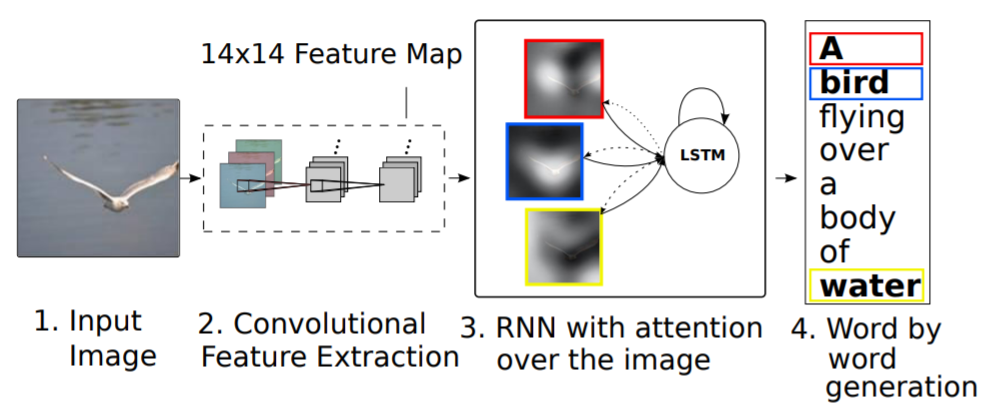
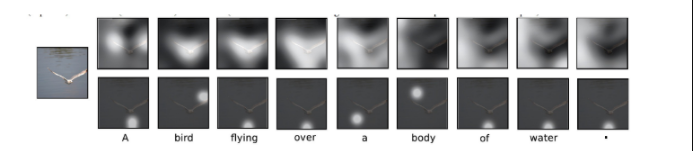

## Key Performance Indicatior

BLEU is a well-acknowledged metric to measure the similarly of one hypothesis sentence to multiple reference sentences.

The primary task for a BLEU implementor is to compare n-grams of the candidate with the n-grams of the reference and count the number of matches. These matches are position-independent.

Given a single hypothesis sentence and multiple reference sentences, it returns value between 0 and 1. The metric close to 1 means that the two are very similar. 

**The more the matches, the better the candidate is.**

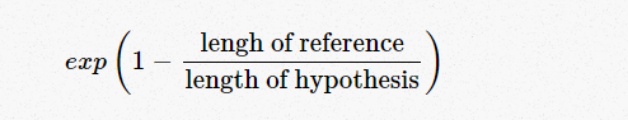

## Business Objectives and Constraints

- Predict correct caption for the input image.
- Incorrect caption could have a negative impact on the user.
- Latency constraints - Max prediction time 5s.

&nbsp;

## Specifications, Imports and Versions

**Hardware Specifications**

- Laptop Model: Dell XPS 15 9570
- Processor: i7-8750H
    - Number of Cores: 6
    - Number of Threads: 12
    - Max Clock Speed: 4.10 GHz
    - Cache: 9MB
- RAM:
    - Capacity: 16 GB
    - Speed: DDR4-2666MHz
    - CAS: 19
- GPU: NVIDIA 1050TI MAX-Q
    - Max Available Memory: 4096 MB
    - Max Clock Speed (boost): 1417 MHz

**Software Specifications**

- OS: Linux Based
    - Flavour: Debian Ubuntu 
    - Version: 20.04 LTS - Focal Fossa
- Anaconda Version: Miniconda3

**Imports**

In [1]:
import sys, time, os, warnings 

import tensorflow as tf
import keras
import numpy as np
import pandas as pd 
warnings.filterwarnings("ignore")

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Version: ")
print(f"Python {sys.version}")
print(f"Keras {keras.__version__}")
print(f"Tensorflow {tf.__version__}")

Version: 
Python 3.9.2 | packaged by conda-forge | (default, Feb 21 2021, 05:02:46) 
[GCC 9.3.0]
Keras 2.4.3
Tensorflow 2.4.1


## Loading Data

**Dataset Used:** 
- Name: Flickr30k dataset
- url: https://www.kaggle.com/hsankesara/flickr-image-dataset
- Size(unzipped): 8.8GB

In [3]:
helper_path = os.path.dirname(os.getcwd())

dataset_images = os.path.join(helper_path, "data/flickr30k_images")
dataset_captions = os.path.join(helper_path, "data/captions.csv")

df_captions = pd.read_csv(dataset_captions, sep='|', engine='python', header=0, names=["filename", "caption_idx", "caption"])
df_captions.head()

,filename,caption_idx,caption
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [4]:
# Shows rows with NaN
df_captions[df_captions.isnull().any(axis=1)]

,filename,caption_idx,caption


&nbsp;

## Exploratory Data Analysis

### Inspecting total images and captions

In [5]:
print(f"Total number of Images are: {len(os.listdir(dataset_images))}")
print(f"Total number of Captions are: {len(df_captions)}")

print(f"Number of unique filenames are: {len(np.unique(df_captions.filename.values))}")
print(f"Captions per Image: {len(df_captions)//len(np.unique(df_captions.filename.values))}")

Total number of Images are: 63566
Total number of Captions are: 158915
Number of unique filenames are: 31783
Captions per Image: 5


### Inspecting images and their corresponding captions

Shape of imag: (500, 333, 3)


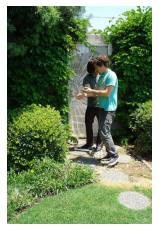

In [6]:
filename = os.path.join(dataset_images, df_captions["filename"][0])
img = plt.imread(filename)
plt.axis('off')

print(f"Shape of imag: {img.shape}")
plt.imshow(img) 

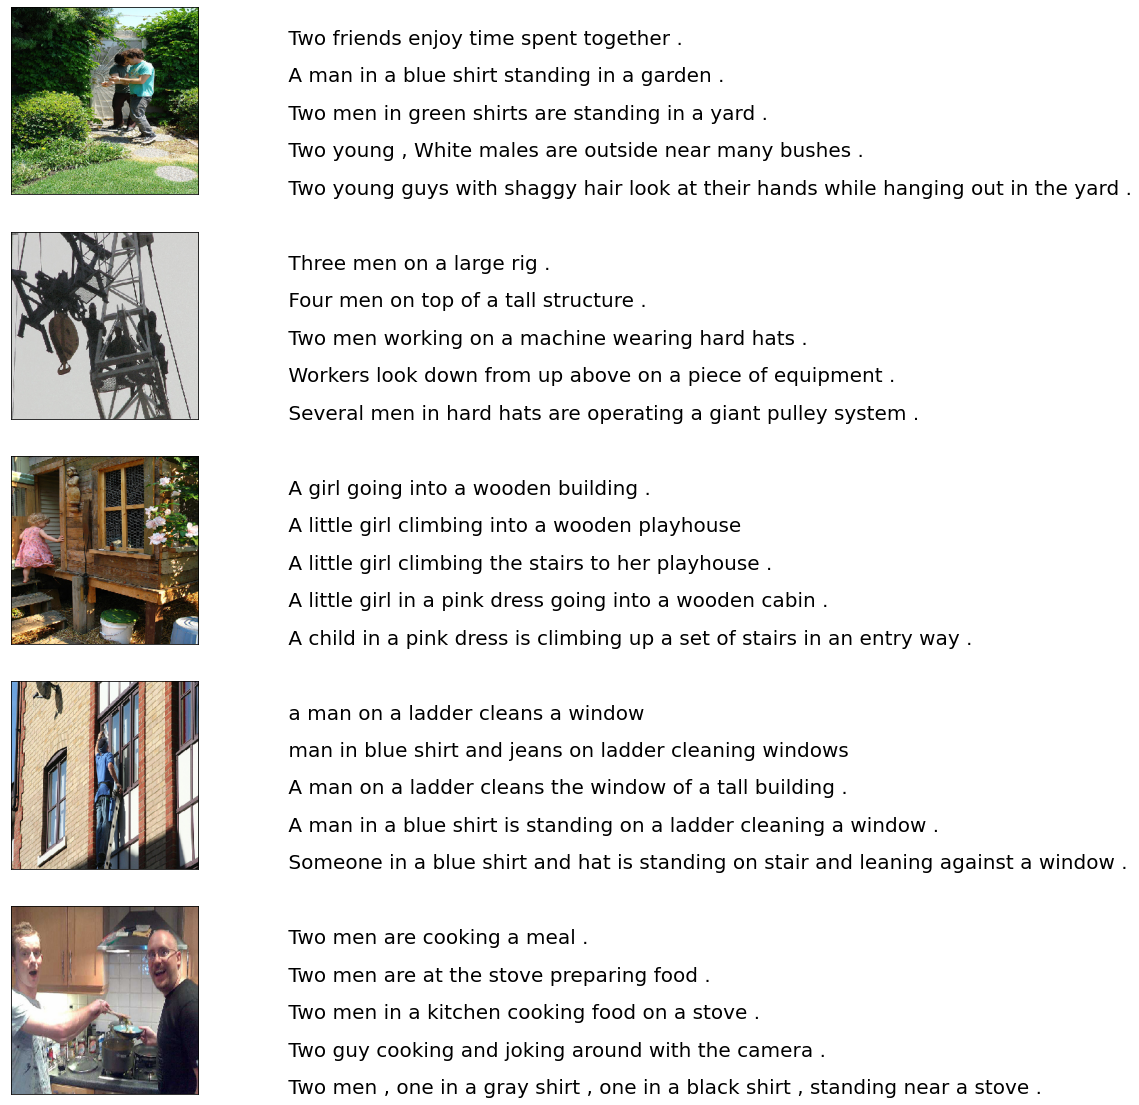

In [7]:
from keras.preprocessing.image import load_img, img_to_array

count = 1
target_size = (299, 299, 3)

fig = plt.figure(figsize=(10,20))
for img_fname in np.unique(df_captions["filename"])[:5]:
    filename = os.path.join(dataset_images, img_fname)
    captions = list(df_captions["caption"].loc[df_captions["filename"]==img_fname].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(5, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(5, 2, count)
    plt.axis('off')
    ax.plot()
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
    
plt.show()

### Caption Vocabulary

In [8]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

tokenized_sent = [word_tokenize(str(i)) for i in df_captions["caption"].str.lower()]
tokenized_sent[0:1]

[nltk_data] Downloading package punkt to /home/apollo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['two',
  'young',
  'guys',
  'with',
  'shaggy',
  'hair',
  'look',
  'at',
  'their',
  'hands',
  'while',
  'hanging',
  'out',
  'in',
  'the',
  'yard',
  '.']]

In [9]:
vocab = [word for sent in tokenized_sent for word in sent]
print(f"Size of Vocabulary is: {len(set(vocab))}")

Size of Vocabulary is: 20292


In [10]:
from collections import Counter 

vocab_counter = Counter(vocab)
df_vocab = pd.DataFrame.from_dict(vocab_counter, orient='index').reset_index()
df_vocab.head(5)

,index,0
0,two,21641
1,young,13218
2,guys,658
3,with,36207
4,shaggy,51


In [11]:
df_vocab = df_vocab.rename(columns={'index':'word', 0:'count'})
df_vocab = df_vocab.sort_values(by='count', ascending=False)
df_vocab = df_vocab.reset_index()[["word", "count"]]

print(f"Most Frequent Words: \n{df_vocab.head(5)}")
print(f"\nLeast Frequent Words: \n{df_vocab.tail(5)}")

Most Frequent Words: 
  word   count
0    a  271705
1    .  151066
2   in   83466
3  the   62979
4   on   45669

Least Frequent Words: 
             word  count
20287   panicking      1
20288   hill-side      1
20289  exclaiming      1
20290     shapely      1
20291    scrolled      1


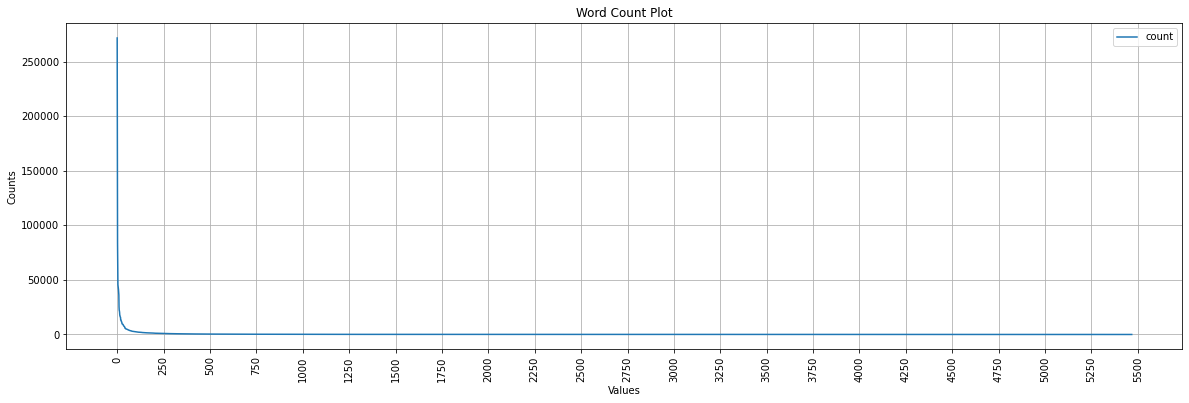

In [12]:
# Word Count for all words with more than 10 counts
df_vocab[df_vocab["count"] >= 10].plot(grid=True,figsize=(20,6))
plt.title("Word Count Plot")
plt.xlabel("Values")
plt.xticks(np.arange(0, 5550, 250), rotation="vertical")
plt.ylabel("Counts")

plt.show()

Text(0.5, 1.0, 'Word vs Count: Top-50 words')

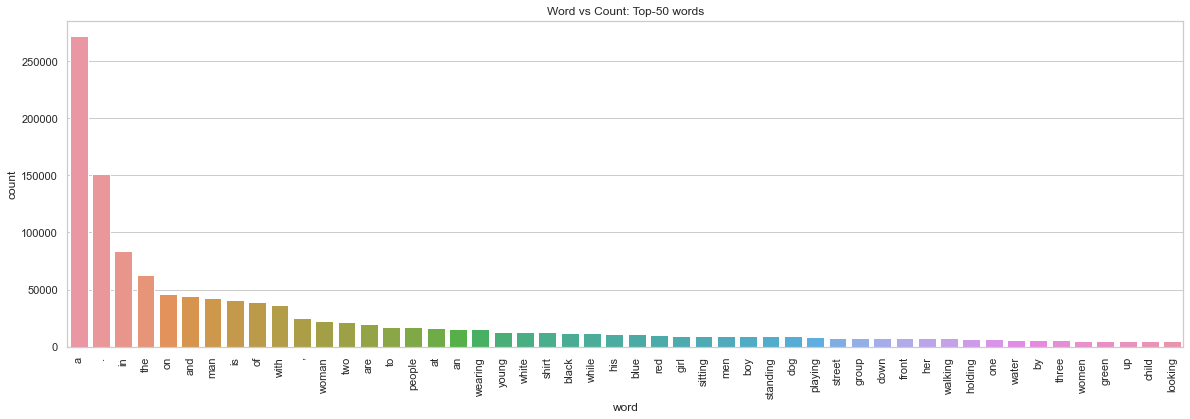

In [13]:
# Top 50 most occuring words
sns.set(style="whitegrid")
plt.figure(figsize=(20,6))
sns.barplot(x="word", y="count", data=df_vocab[:50])
plt.xticks(rotation="vertical")
plt.title("Word vs Count: Top-50 words")

Text(0.5, 1.0, 'Word vs Count: Least-50 words')

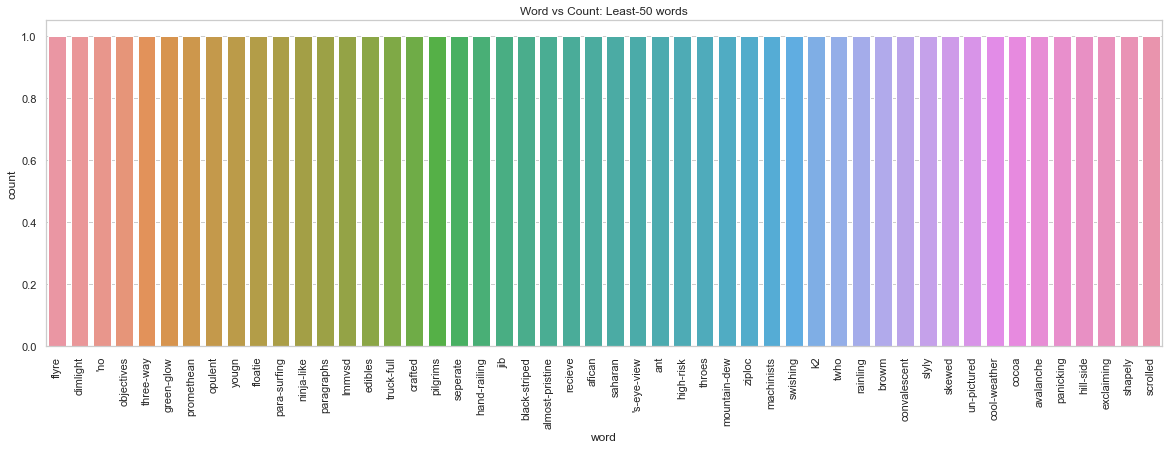

In [14]:
# Top 50 least occuring words
sns.set(style="whitegrid")
plt.figure(figsize=(20,6))
sns.barplot(x="word", y="count", data=df_vocab[-50:])
plt.xticks(rotation="vertical")
plt.title("Word vs Count: Least-50 words")

Text(0.5, 1.0, 'Average Caption Length')

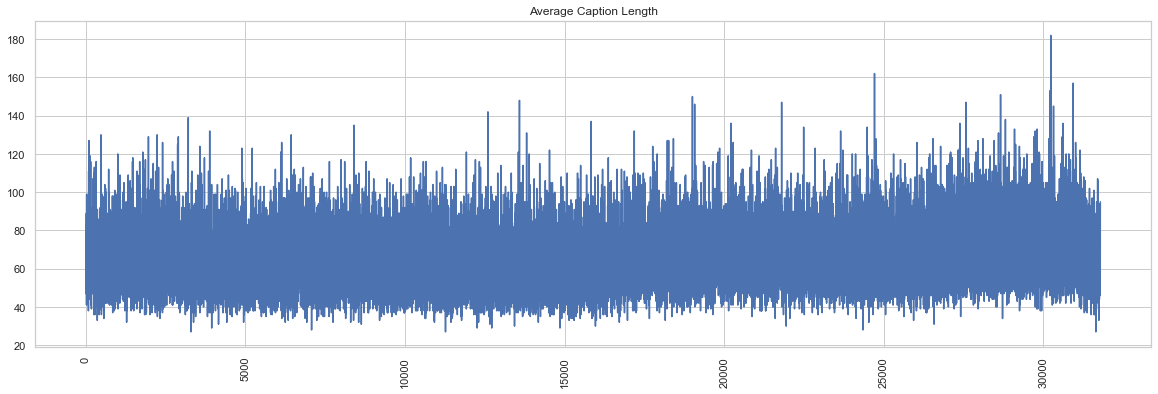

In [15]:
# Average Length of caption
caption_len = [len(str(i)) for i in df_captions["caption"]]
avg_caption_len = [sum(caption_len[i:i+5])//5 for i in range(0, len(caption_len), 5)]

sns.set(style="whitegrid")
plt.figure(figsize=(20,6))
sns.lineplot(y=avg_caption_len, x=np.arange(0, len(avg_caption_len)))
plt.xticks(rotation="vertical")
plt.title("Average Caption Length")

&nbsp;

## Pre-Processing Captions

###  Add start and end sequence tokens

For training our Language model, we predefine our label and target text.  
For example, if the caption is “A man and a girl sit on the ground to eat.”, our label and target would be as follows:

Label – [<start<start>>, A,  man,  and,  a, girl,  sit,  on,  the,  ground,  to,  eat,  <end<start>> ] 
    
Target – [ A, man,  and,  a,  girl,  sit,  on,  the,  ground,  to,  eat,  ., <<end>> ]

This is done so that our model understands the start and end of our labelled sequence.

In [16]:
train_captions, train_imgs_path = shuffle(list(df_captions["caption"]), list(df_captions["filename"]), random_state=42)

In [17]:
for i in range(0, len(train_imgs_path)):
    train_imgs_path[i] = os.path.join(dataset_images, train_imgs_path[i])

train_imgs_path[:5]

['/home/apollo/Desktop/DJSCE/Projects/neural_image_captioning/data/flickr30k_images/5797756884.jpg',
 '/home/apollo/Desktop/DJSCE/Projects/neural_image_captioning/data/flickr30k_images/109260218.jpg',
 '/home/apollo/Desktop/DJSCE/Projects/neural_image_captioning/data/flickr30k_images/5087543347.jpg',
 '/home/apollo/Desktop/DJSCE/Projects/neural_image_captioning/data/flickr30k_images/450596617.jpg',
 '/home/apollo/Desktop/DJSCE/Projects/neural_image_captioning/data/flickr30k_images/226481576.jpg']

In [18]:
for i in range(0, len(train_captions)):
    train_captions[i] = "<start>" + train_captions[i] + "<end>"

train_captions[:5]

['<start> A man is sitting on an upturned white bucket playing a banjo .<end>',
 '<start> Spelunkers pose inside a rock cavern while bathed in sunlight from the surface .<end>',
 '<start> A toddler enjoying her birthday cake .<end>',
 '<start> Two people are walking by the ocean .<end>',
 '<start> Young , smiling , blond female police officer from New York standing outside on a sidewalk .<end>']

In [19]:
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

cap_vector.shape

(158915, 80)

### Generate GloVe Embeddings

In [20]:
embeddings_index = {} # empty dictionary
embeds = open(os.path.join(helper_path, "notebooks/glove.6B.300d.txt"), encoding="utf-8")

for line in embeds:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
embeds.close()

f"Found {len(embeddings_index)} word vectors"

'Found 400000 word vectors'

In [21]:
VOCAB_LEN = len(tokenizer.word_index)+1
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((VOCAB_LEN, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.97120005e-01,  9.40489992e-02, -9.66619998e-02, ...,
         5.97169995e-02, -2.28530005e-01,  2.96020001e-01],
       ...,
       [ 5.65919995e-01,  5.07629991e-01,  3.30489993e-01, ...,
         2.51739994e-02,  3.34049982e-05, -2.27530003e-02],
       [ 7.07489997e-02,  1.60799995e-01,  2.18300000e-01, ...,
         1.41980007e-01,  6.34789988e-02, -1.40410006e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Pre-Processing Images

### Verifying image filename

In [22]:
import re

flag = 1
for i in df_captions["filename"]:
    if re.search("([^\s]+(\.(?i)(jpg|png|gif|bmp))$)", i):
        pass
    else:
        flag = 0
        print(f"Invalid Filename: {i}")

if flag:
    print("All filenames are valid")

All filenames are valid


&nbsp;

## Model Building and Feature Extraction

### Customizing InceptionResNetV2 Model

In [23]:
INPUT_SHAPE = (224, 224, 3)
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 37
NUM_STEPS = len(train_imgs_path)//BATCH_SIZE
BUFFER_SIZE = 1589
UNITS = 300

In [24]:
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, Bidirectional, TimeDistributed

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing import image

In [25]:
encoder_model = InceptionResNetV2(include_top=False, weights="imagenet")

input_layer = encoder_model.input
hidden_layer = encoder_model.output
model1 = Model(input_layer, hidden_layer)

keras.backend.clear_session()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Feature Vector Extraction from the Pre-trained model

In [26]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = preprocess_input(img)
   
    return img, image_path

In [27]:
encode_train = sorted(set(train_imgs_path))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

image_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

In [40]:
from tqdm import tqdm

for img, path in tqdm(image_dataset):
    batch_features = model1(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for features, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, features.numpy())

100%|██████████| 859/859 [45:41<00:00,  3.19s/it]


In [29]:
features.numpy().shape

NameError: name 'features' is not defined

### Split data into training and testing set

In [28]:
# Calculates the max_length, used to store the attention weights
MAX_LEN = max(len(tensor) for tensor in train_seqs)


# Create training and validation sets using an 75-25 split
img_train, img_val, cap_train, cap_val = train_test_split(train_imgs_path, cap_vector, test_size=0.25, random_state=42)

MAX_LEN

80

In [29]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8') + '.npy')
    
    return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Building LSTM Model

In [30]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units=UNITS):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, axis=1)
        
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [31]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, Dropout, TimeDistributed

class BiDirLSTMDecoder(tf.keras.Model):
    def __init__(self, embedding_dim=EMBEDDING_DIM, units=UNITS, vocab_length=VOCAB_LEN, embedding_matrix=embedding_matrix, max_length=MAX_LEN):
        super(BiDirLSTMDecoder, self).__init__()
        self.units = units
        
        self.embedding = Embedding(input_dim=vocab_length, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False)
        self.bidirectional1 = Bidirectional(LSTM(units=self.units, return_sequences=True), merge_mode='sum')
        self.time = TimeDistributed(Dense(embedding_dim, activation='sigmoid'))
        
        self.dense1 = Dense(self.units)
        self.dense2 = Dense(vocab_length)
        
        self.attention = BahdanauAttention(self.units)
        
    def call(self, language_model, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        language_model = self.embedding(language_model)
        language_model = tf.concat([tf.expand_dims(context_vector, 1), language_model], axis=-1)
        
        language_model = self.bidirectional1(language_model)
        state = tf.squeeze(language_model, [1])
        language_model = self.time(language_model)

        language_model = self.dense1(language_model)
        language_model = tf.reshape(language_model, (-1, language_model.shape[2]))
        language_model = self.dense2(language_model)

        return language_model, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### Build Final CNN Encoder Model

In [32]:
class CNNEncoder(tf.keras.Model):
    def __init__(self, embedding_dim=EMBEDDING_DIM):
        super(CNNEncoder, self).__init__()
        self.dense = Dense(embedding_dim)

    def call(self, layer):
        layer = tf.nn.dropout(layer, rate=0.5, seed=42)
        layer = self.dense(layer)
        layer = tf.nn.relu(layer)
        
        return layer

In [33]:
cnn_encoder = CNNEncoder()
lstm_decoder = BiDirLSTMDecoder()

&nbsp;

## Training

### Basic Setup

In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [35]:
checkpoint_path_ckpt = os.path.join(helper_path, "model/checkpoint")
ckpt = tf.train.Checkpoint(encoder=cnn_encoder,
                           decoder=lstm_decoder,
                           optimizer = optimizer)

In [36]:
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

### Model Training

- We extract the features stored in the respective `.npy` files and then pass those features through the encoder.
- The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
- The decoder returns the predictions and the decoder hidden state.
- The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
- Use teacher forcing to decide the next input to the decoder.
> Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
- The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [37]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    hidden = lstm_decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = cnn_encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, attention_weights = lstm_decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = cnn_encoder.trainable_variables + lstm_decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f"Epoch: {epoch+1}  Batch: {batch} Loss: {round(batch_loss.numpy() / int(target.shape[1]), 3)}")

    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f"Epoch: {epoch+1} Loss {round(total_loss/num_steps, 4)}")
    print(f"Time taken: {time.time() - start} sec\n")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpzsus85jw.py, line 28)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpzsus85jw.py, line 28)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
